# Проект 3 - Рыночная стоимость объектов недвижимости

## Введение

**Описание проекта**

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

Задача — установить параметры для определения рыночной стоимости объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных: первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Описание данных**

В таблице 22 столбца:

1. `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
2. `balcony` — число балконов
3. `ceiling_height` — высота потолков (м)
4. `cityCenters_nearest` — расстояние до центра города (м)
5. `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
6. `first_day_exposition` — дата публикации
7. `floor` — этаж
8. `floors_total` — всего этажей в доме
9. `is_apartment` — апартаменты (булев тип)
10. `kitchen_area` — площадь кухни в квадратных метрах (м²)
11. `last_price` — цена на момент снятия с публикации
12. `living_area` — жилая площадь в квадратных метрах (м²)
13. `locality_name` — название населённого пункта
14. `open_plan` — свободная планировка (булев тип)
15. `parks_around3000` — число парков в радиусе 3 км
16. `parks_nearest` — расстояние до ближайшего парка (м)
17. `ponds_around3000` — число водоёмов в радиусе 3 км
18. `ponds_nearest` — расстояние до ближайшего водоёма (м)
19. `rooms` — число комнат
20. `studio` — квартира-студия (булев тип)
21. `total_area` — площадь квартиры в квадратных метрах (м²)
22. `total_images` — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, которые не относятся к жилому фонду, но имеют необходимые условия для проживания.

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Простые артефакты
2. Пропущенные значения и типы данных
3. Дополнительные параметры

Пойдем по порядку.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Я привык сохранять исходный датасет, чтобы можно было проследить какие преобразования были совершены.
raw_properties = pd.read_csv('raw_real_estate.csv', sep='\t')
df_properties = raw_properties.copy()

# Посмотрим размеры датасета
print('-' * 50)
print('Размер датасета (строки, столбцы):', df_properties.shape)
print('-' * 50)

# Выведем на экран информацию о датасете
df_properties.info()

--------------------------------------------------
Размер датасета (строки, столбцы): (23699, 22)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          2

Во-первых, колонки уже имеют более-менее нормальный тип данных (целочисленное количество этажей `floor`, например). За исключением `is_apartment`, которая явно должна быть `bool`, а также парочки других виноватых.

Во-вторых, колонки имеют разное количество строк. Это говорит о том, что некоторые значения отсутствуют.

В-третьих, непохоже, что у нас нет идентификаторов категорий, которые можно вынести в отдельные словари.

In [21]:
# Причешем это безобразие
df_properties.rename(columns={'cityCenters_nearest': 'city_center_nearest',
                              'studio': 'is_studio',
                              'open_plan': 'is_open_plan',
                              'locality_name': 'location_name',
                              'ponds_around3000': 'ponds_around_3km',
                              'parks_around3000': 'parks_around_3km'}, inplace=True)

# Выведем на экран первые строчки
display(df_properties.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,location_name,airports_nearest,city_center_nearest,parks_around_3km,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


По первым 10 строчкам уже видно, что нас ждут приключения!

### Простые артефакты

В наших данных есть небольшое количество строк с явно странными значениями, которые будут дальше мешать нам жить.

In [22]:
# Посмотрим, что за значения внутри
display(round(df_properties[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()))

,total_area,last_price,rooms,ceiling_height
count,23699.0,23699.0,23699.0,14504.0
mean,60.0,6541549.0,2.0,3.0
std,36.0,10887013.0,1.0,1.0
min,12.0,12190.0,0.0,1.0
25%,40.0,3400000.0,1.0,3.0
50%,52.0,4650000.0,2.0,3.0
75%,70.0,6800000.0,3.0,3.0
max,900.0,763000000.0,19.0,100.0


Сразу видно виноватых: у нас есть `total_area` почти 900 м^2, `last_price` в 763М рублей (!), и `ceiling_height` 100 м. Первые два артефакта, скорей всего, настоящие квартиры, просто очень большие. Последний же артефакт - явно ошибка.

Посмотрим как это выглядит на графиках.

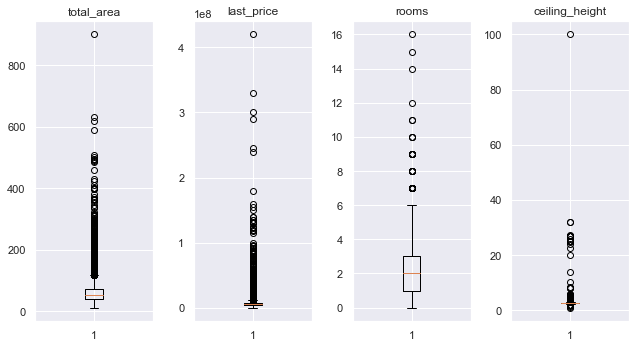

In [23]:
def fun_get_boxplots_for_columns(df, columns, num_rows, num_columns):
    """
    This function creates a num_rows x num_columns box subplots for a list of columns out of the dataset.

    Args:
        df (DataFrame): dataframe with data to show
        columns (List): list of columns to plot
        num_rows (int): number of rows in subplots
        num_columns (int): number of columns in subplots
    """
    # Для начала коробки с усами
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(9, 5))

    # Добавим каждый бокс-с-усами к фигуре
    for i, ax in enumerate(axs.flat):
        ax.boxplot(df[columns].dropna().iloc[:, i])
        ax.set_title(df[columns].columns[i])

    # Сделаем нормальный формат графиков и удалим ненужные переменные
    plt.tight_layout()

fun_get_boxplots_for_columns(df_properties, ['total_area', 'last_price', 'rooms', 'ceiling_height'], 1, 4)

У нас очень много выбивающихся значений!
1. С `total_area` ситуация выглядит более-менее правдоподобно - у нас могут быть квартиры любого размера.
2. В `rooms` у нас есть нули - это, вероятно квартиры-студии. Сделаем их всех однокомнатными. Также у нас есть квартиры-отели с более чем 10 комнатами. Избавимся от них тоже.
3. У `last_price` есть длинный хвост из больших и редких значений - я думаю, что его надо обрезать где-то на `5e7` (это также обрежет все остальные колонки).
4. Наконец, `ceiling_height` тоже странный хвост из значений более 5 метров. Их мы тоже обрежем, т.к. нас не интересуют ангары в этом упражнении.

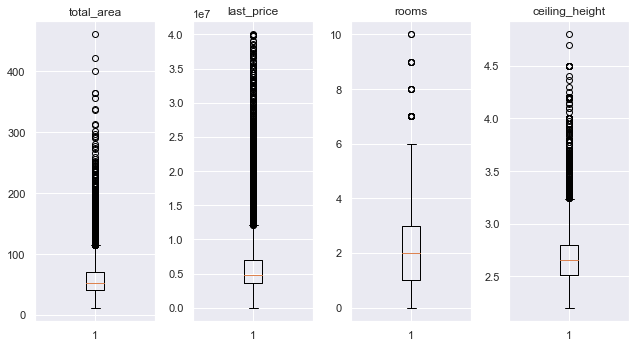

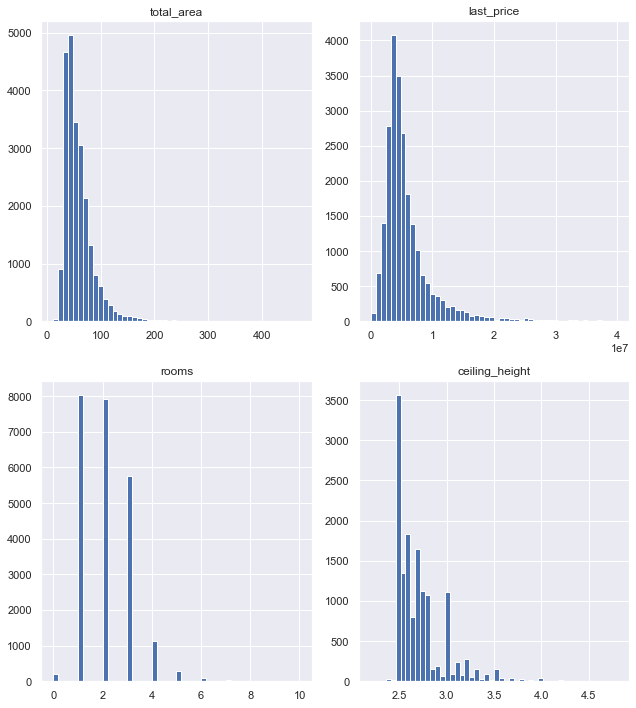

In [24]:
# Уберем странные значения из ceiling_height
df_properties = df_properties[(df_properties.ceiling_height < 5) &
                              (df_properties.ceiling_height > 2) |
                              (df_properties.ceiling_height.isna())]

# Уберем странные значения из last_price
df_properties = df_properties[df_properties.last_price < 4e7]

# Уберем странные значения к rooms
df_properties = df_properties[df_properties.rooms <= 10]

# Посмотрим на новую коробку-с-усами
fun_get_boxplots_for_columns(df_properties, ['total_area', 'last_price', 'rooms', 'ceiling_height'], 1, 4)

# Посмотрим на гистрограммы: площадь, цена, число комнат, высота потолков
df_properties[['total_area', 'last_price', 'rooms', 'ceiling_height']].hist(bins=50, figsize=(9, 10))

# Нормальный формат графика
plt.tight_layout()

### Пропущенные значения и типы данных

Сначала разберемся с попущенными значениями - глядишь, некоторые из них можно восстановить.

In [25]:
# Найдем колонки с пропущенными значениями через функцию - нам надо будет сделать это пару раз
def fun_get_columns_with_nan(df):
    """
    This function returns a list of column names, which have NaN values from an input data frame.

    Args:
        df (DataFrame): A dataframe to check

    Returns:
        columns_with_nan (list): A list of column names which have NaNs inside 
    """
    # Пустой лист
    columns_with_nan = []

    # Найдем виноватых
    for column in df.columns:
        if df[column].isna().sum() > 0:
            columns_with_nan.append(column)
    return columns_with_nan

# Посмотрим на них
display(df_properties[fun_get_columns_with_nan(df_properties)].head())

,ceiling_height,floors_total,living_area,is_apartment,kitchen_area,balcony,location_name,airports_nearest,city_center_nearest,parks_around_3km,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition
0,2.70,16.0,51.0,NaN,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,NaN,11.0,18.6,NaN,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,NaN,5.0,34.3,NaN,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
4,3.03,14.0,32.0,NaN,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,NaN,12.0,14.4,NaN,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0


Начнем заполнять. `is_apartment` - думаю, правильно предположить, что если `NaN`, то значение должно быть `False`. Количество балконов `balcony`, если не указано, что, вероятно, равно нулю.

`ceiling_height`, `kitchen_area` и `living_area` можно попробовать вычислить как пропорциональные значения от суммарной площади квартиры `total_area` в зависимости от количества комнат.

Наконец, `floors_total`, `location_name` и `days_exposition` - придется оставить пустыми. Значения в этих колонках нельзя найти логическими путями и они не зависят от других колонок.

Скорей всего, человек просто не ввел все эти данные, когда оставлял объявление.

Колонку `city_center_nearest` придется тоже оставить в покое, т.к. точного адреса у нас нет. Видимо, автоматические алгоритмы не определили какой город ближайший.

Остальные колонки `airports_nearest`, `parks_around_3km`, `parks_nearest`, `ponds_around_3km`, `ponds_nearest` мы убьем, потому что в задании они не используются.

In [26]:
# Уберем колонки, которые не нужны
df_properties.drop(['airports_nearest',
                    'parks_around_3km',
                    'parks_nearest',
                    'ponds_around_3km',
                    'ponds_nearest'], axis=1, inplace=True)

Разберемся с пропусками.

In [27]:
# Eсли пусто - сделаем False для is_apartment
df_properties.is_apartment.fillna(False, inplace=True)

# Если пусто - сделаем 0 для balcony
df_properties.balcony.fillna(0, inplace=True)

# Если ноль - сделаем 1 для rooms
df_properties.rooms.replace(0, 1, inplace=True)

# Разберемся с ceiling_height
df_properties.ceiling_height.fillna(df_properties
                                    .groupby('rooms')
                                    .ceiling_height
                                    .transform('mean'), inplace=True)

# Найдем какую долю от общей площади составляют living_area & kitchen_area
df_properties['living_to_total_area'] = df_properties.living_area / df_properties.total_area
df_properties['kitchen_to_total_area'] = df_properties.kitchen_area / df_properties.total_area

# Заполним пропущенные значения для living_to_total_area и kitchen_to_total_area
df_properties.living_to_total_area.fillna(df_properties
                                    .groupby('rooms')
                                    .living_to_total_area
                                    .transform('mean'), inplace=True)

df_properties.kitchen_to_total_area.fillna(df_properties
                                    .groupby('rooms')
                                    .kitchen_to_total_area
                                    .transform('mean'), inplace=True)

# Заполним пропущенные значения для living_area и kitchen_area
df_properties.living_area.fillna( df_properties.living_to_total_area * df_properties.total_area, inplace=True )
df_properties.kitchen_area.fillna( df_properties.kitchen_to_total_area * df_properties.total_area, inplace=True )

# Посмотрим что получилось
print('Количество пропущенных значений, которые вырезали из датасета:',
      len(raw_properties) - len(df_properties))
print('Доля пропущенных значений, которые вырезали из датасета:',
      round(len(df_properties) / len(raw_properties), 2), '%' )
print('Количество пропущенных значений, которые оставили в датасете:')
print(df_properties[fun_get_columns_with_nan(df_properties)].isna().sum())

Количество пропущенных значений, которые вырезали из датасета: 247
Доля пропущенных значений, которые вырезали из датасета: 0.99 %
Количество пропущенных значений, которые оставили в датасете:
floors_total             85
location_name            49
city_center_nearest    5495
days_exposition        3127
dtype: int64


Выглядит уже хорошо - всего 1% данных выбросили из датасета. Хотя еще почти 25% строк не имеют значений в колонке `city_center_nearest`, которая нам понадобится даже в анализе.

Посденим шагом в этой главе исправим типы данных в колонках.

In [28]:
display(df_properties.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23452 entries, 0 to 23698
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_images           23452 non-null  int64  
 1   last_price             23452 non-null  float64
 2   total_area             23452 non-null  float64
 3   first_day_exposition   23452 non-null  object 
 4   rooms                  23452 non-null  int64  
 5   ceiling_height         23452 non-null  float64
 6   floors_total           23367 non-null  float64
 7   living_area            23452 non-null  float64
 8   floor                  23452 non-null  int64  
 9   is_apartment           23452 non-null  bool   
 10  is_studio              23452 non-null  bool   
 11  is_open_plan           23452 non-null  bool   
 12  kitchen_area           23452 non-null  float64
 13  balcony                23452 non-null  float64
 14  location_name          23403 non-null  object 
 15  ci

None

### Дополнительные параметры

В рамках нашего упражнения нам понадобятся несколько дополнительных колонок. Они будут использованы для классификации данных, а также для поиска зависимостей в них. Колонки, которые мы добавим:

1. Цена квадратного метра
2. День недели, месяц и год публикации объявления
3. Этаж квартиры: первый, последний или другой
4. Отношение жилой к общей площади и отношение площади кухни к общей

Последний пункт мы уже сделали в предыдущей главе для заполнения пропущенных значений.

In [29]:
# Цена квадратного метра
df_properties['price_per_sqm'] = df_properties.last_price /  df_properties.total_area

# День недели, месяц и год публикации объявления
df_properties['first_day_exposition'] = pd.to_datetime(df_properties.first_day_exposition)
df_properties['week_day'] = df_properties.first_day_exposition.dt.weekday
df_properties['month'] = df_properties.first_day_exposition.dt.month
df_properties['year'] = df_properties.first_day_exposition.dt.year

# Напишем функцию для категоризации этажей
def fun_floor_categorizer(df):
    """
    This function categorises floor number. It returns 'first', 'last' or 'other'

    Args:
        df (DataFrame): a dataframe with 'floors_total' and 'floor' columns

    Returns:
        (str): floor category
    """
    floor = df.floor
    floors_total = df.floors_total
    if (floor == floors_total) & (floor != 1):
        return 'последний'
    elif floor == 1:
        return 'первый'
    else:
        return 'другой'

# Сделаем категоризацию floor
df_properties['floor_type'] = df_properties.apply( fun_floor_categorizer, axis=1 )

## Исследовательский анализ данных

### Время продажи квартиры

Изучим время продажи квартиры: построим гистограмму, посчитаем среднее и медиану.

count    20325.000000
mean       179.811218
std        218.760355
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

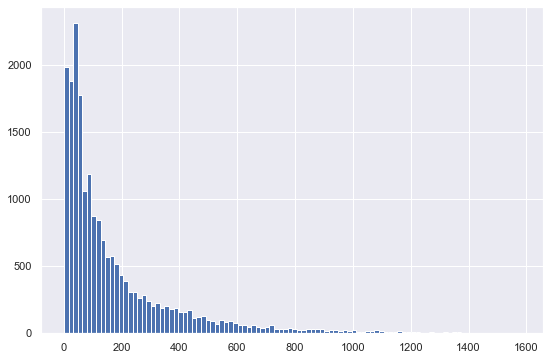

In [30]:
# График и основная статистика
df_properties.days_exposition.dropna().hist(bins=100, figsize=(9, 6));
df_properties.days_exposition.describe()

**Вывод:** распеределение времени продажи имеет характерную форму: у нас есть небольшой пик в начале, а дальше длинный хвост значений в конце. Обычная (средняя) продажа займет около 180 дней, хотя половина всех продаж заняла менее 95 дней. Если квартира была продана меньше, чем за 45 дней - это очень быстро. А если более чем 230 дней - необычно долго.

### Факторы влияющие на стоимость квартиры

Посмотрим, что влияет на стоимость квартиры во всем датасете.

#### Параметры и расположение квартиры

Для начала возьмем колонки `last_price`, `total_area`, `rooms`, `city_center_nearest`.

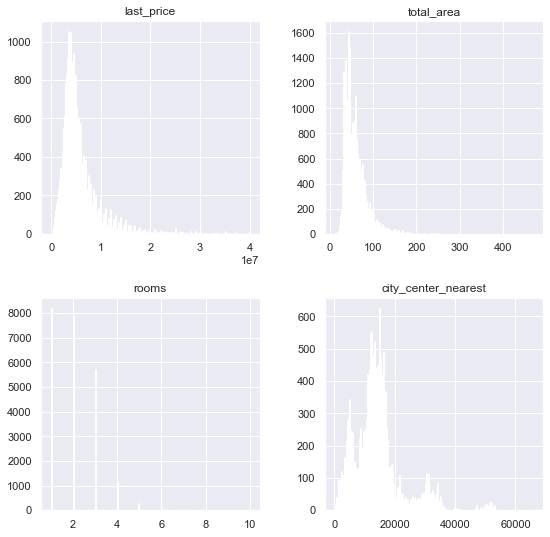

In [31]:
# Посмотрим на распределения
df_properties[['last_price', 'total_area', 'rooms', 'city_center_nearest']].hist(bins=200, figsize=(9, 9));

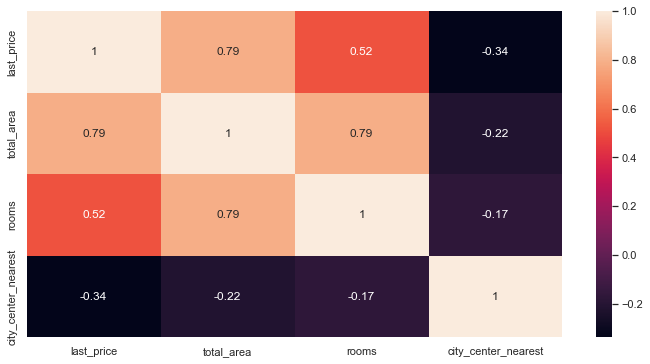

In [32]:
# И корреляционную матрицу
sns.set(rc = {'figure.figsize':(12, 6)})
sns.heatmap(df_properties[['last_price', 'total_area', 'rooms', 'city_center_nearest']].corr(), annot=True);

**Вывод:** Самым большим влиянием на цену оказывает площадь квартиры - что ожидаемо. Количество комнат также имеет некоторое влияние, но сильно меньше, чем площадь. Наконец, удаленность от центра имеет отрицательную корреляцию с ценой (чем расстояние меньше - тем цена выше) и является самым слабым фактором из трех.

#### Этаж квартиры и время размещения

Посмотрим теперь на зависимость от того, на каком этаже расположена квартира и даты размещения.

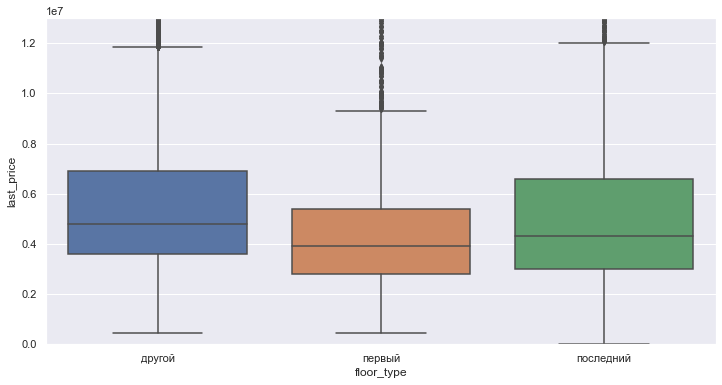

In [33]:
# Цена в зависимости от этажа
sns.boxplot(data=df_properties, x='floor_type', y='last_price');
plt.ylim([0, 1.3e7]);

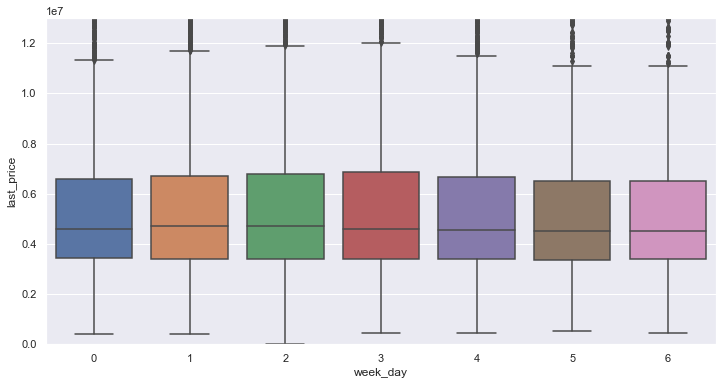

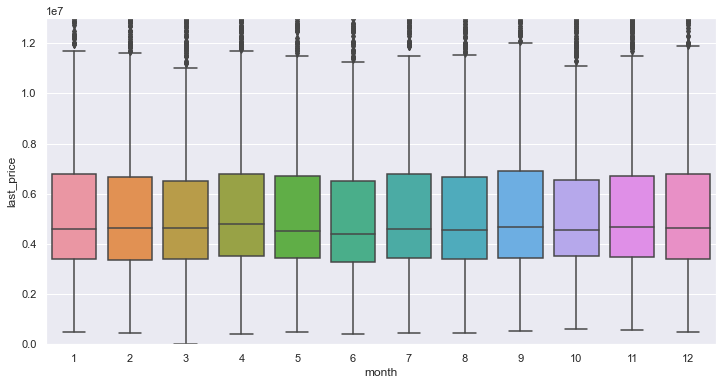

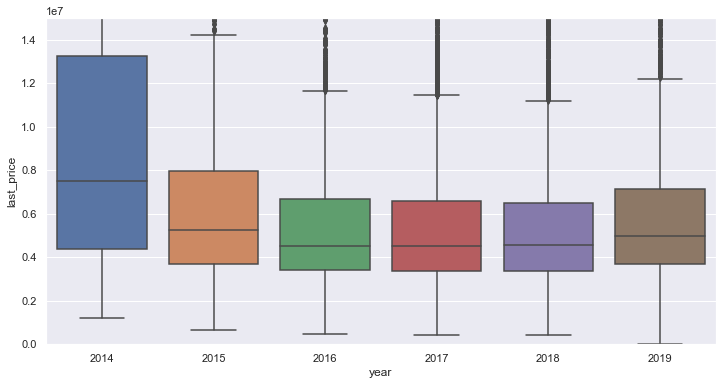

In [34]:
# Цена в зависимости от даты размещения - по дням
plt.figure()
sns.boxplot(data=df_properties, x='week_day', y='last_price');
plt.ylim([0, 1.3e7]);

# Цена в зависимости от даты размещения - по месяцам
plt.figure()
sns.boxplot(data=df_properties, x='month', y='last_price');
plt.ylim([0, 1.3e7]);

# Цена в зависимости от даты размещения - по годам
plt.figure()
sns.boxplot(data=df_properties, x='year', y='last_price');
plt.ylim([0, 1.5e7]);

**Вывод:** Цена явно зависит от этажа на котором находится квартира: квартиры на первом этаже более дешевые, чем на остальных этажах. Цена квартир на последнем этаже чуть сильнее варьируется, чем цена на других этажах, но это, вероятно связано с конкретными случаями: к примеру, жить в башне Меркурий на последнем этаже явно лучше, чем в пятиэтажной хрущевке.

Как и ожидалось, цена почти не зависит от дня недели или месяца подачи объявления - все распределения более-менее одинаковые. Цена по годам менялась заметно (предполагая, что остальные параметры одинаковые) - так в 2014 году вариативность цен была сильно выше, как и мединные занчения. После 2014 года был явный тренд на падение цен на недвижимость. Этот тренд начал разворот в 2019 году. Опять же, все эти выводы предварительные, т.к. в идеале надо убедиться, что внутри каждого среза остальные параметры (например, средняя площадь квартир) не поменялись.

#### Стоимость жилья по населенным пунктам

Посмотрим, как стоимость жилья меняется в топ-10 населенных пунктах по числу объявлений.

,location_name,ads_recorded,total_property_value,total_sqm_sold,price_per_sqm_avg
0,Санкт-Петербург,15498,1.099846e+11,968993.0,113504.0
1,посёлок Мурино,520,1.910010e+09,22955.0,83208.0
2,посёлок Шушары,440,1.807556e+09,23681.0,76328.0
3,Всеволожск,397,1.505749e+09,22243.0,67695.0
4,Пушкин,368,2.345074e+09,22339.0,104977.0
5,Колпино,338,1.339839e+09,17992.0,74468.0
6,посёлок Парголово,327,1.467600e+09,16848.0,87111.0
7,Гатчина,306,1.067319e+09,15584.0,68487.0
8,деревня Кудрово,299,1.266013e+09,13925.0,90917.0
9,Выборг,235,7.662830e+08,13219.0,57970.0


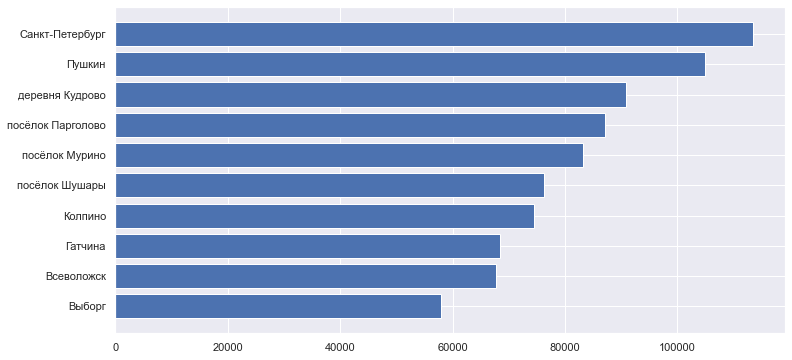

In [35]:
# Сведем данные в таблицу
pvt_top_10_locations = pd.pivot_table(
    data=df_properties,
    index='location_name',
    values=['last_price', 'total_area'],
    aggfunc={'last_price': ['count', 'sum'],
             'total_area': 'sum'})

# Переименуем колонки и отсортируем значения
pvt_top_10_locations.columns = ['ads_recorded', 'total_property_value', 'total_sqm_sold']
pvt_top_10_locations.sort_values(by='ads_recorded', ascending=False, inplace=True)

# Оставим топ-10
pvt_top_10_locations = pvt_top_10_locations.iloc[:10, :].reset_index()

# Посчитаем среднюю стоимость квадратного метра
pvt_top_10_locations['price_per_sqm_avg'] = pvt_top_10_locations.total_property_value / pvt_top_10_locations.total_sqm_sold

# Посмотрим на результат
display(round(pvt_top_10_locations))

# И на график
plt.barh(data=pvt_top_10_locations.sort_values(by='price_per_sqm_avg', ascending=True),
        width='price_per_sqm_avg',
        y='location_name');

**Выводы:** Санкт-Петербург сильно опережает остальные города в датасете по количеству объявлений - 15К штук против нескольких сотен в остальных городах. Санкт-Петербург также оказался самым дорогим (с точки зрения средней цены за квадратный метр городом). За ним следует Пушкин, а потом остальные поселки. Самым дешевым городом для покупки жилья оказался Выборг. Такое распределние цен ожидаемо: Питер, как культурная столица, привлекает больше людей, а значит имеет бОльший спрос на жилье.

#### Квартиры в центральной зоне Санкт-Петербурга

Проверим эмпирическим путем какой примерно радиус у центральной зоны Санкт-Петербурга.

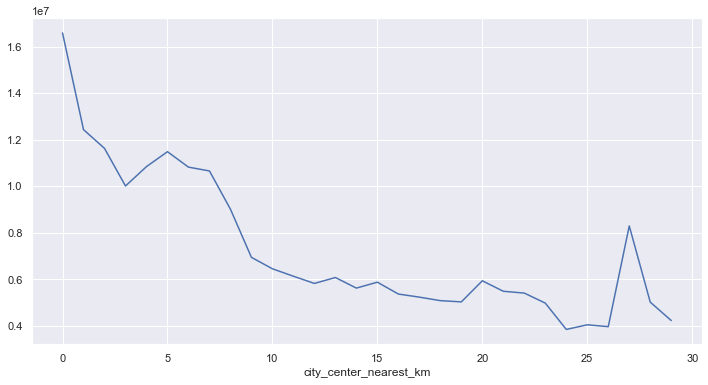

In [36]:
# Добавим расстояние до центра в км
df_properties['city_center_nearest_km'] = round(df_properties.city_center_nearest / 1e3)

# Возьмем объявления только в Питере и построим кривую
df_properties[df_properties.location_name == 'Санкт-Петербург'] \
    [['last_price', 'city_center_nearest_km']] \
    .dropna() \
    .sort_values(by='city_center_nearest_km') \
    .groupby('city_center_nearest_km')['last_price'].mean() \
    .plot(x='city_center_nearest_km', 
          y='last_price');

**Выводы:** по графику зависимости средней цены от расстояния до центра видно, что как только мы пересекаем 7-8 км, цена почти сразу уменьшается в два раза. Видимо, это и есть примерная граница центральной зоны. Интересно, что график довольно неравномерный: на расстоянии 5 км и ~27 км от центра у нас есть всплески средней цены. Скорей всего, это связано с какими-то конкретными районами.

#### Стоимость квартир в центральной зоне

Посмотрим от каких факторов зависит стоимость квартиры в центре. Для анализа возьмем колонки `total_area`, `last_price`, `rooms`, `ceiling_height`, `floor`, `city_center_nearest_km`, `first_day_exposition`.

,total_area,last_price,rooms,ceiling_height
count,3940.0,3940.0,3940.0,3940.0
mean,83.0,10773776.0,3.0,3.0
std,42.0,6783654.0,1.0,0.0
min,12.0,1600000.0,1.0,2.0
25%,54.0,6300000.0,2.0,3.0
50%,74.0,8600000.0,3.0,3.0
75%,100.0,12900000.0,3.0,3.0
max,442.0,39990000.0,10.0,5.0


,total_area,last_price,rooms,ceiling_height
count,23452.0,23452.0,23452.0,23452.0
mean,59.0,5891218.0,2.0,3.0
std,30.0,4535467.0,1.0,0.0
min,12.0,12190.0,1.0,2.0
25%,40.0,3400000.0,1.0,3.0
50%,52.0,4600000.0,2.0,3.0
75%,69.0,6700000.0,3.0,3.0
max,470.0,39990000.0,10.0,5.0


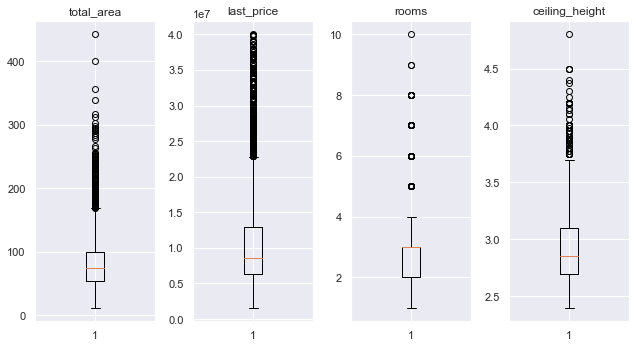

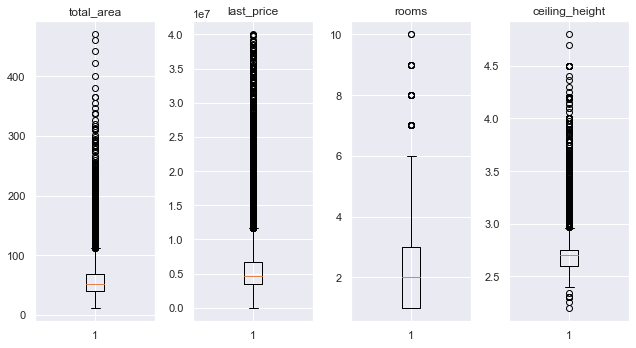

In [37]:
# Сохраним эти квартиры в отдельный датасет
pvt_properties_center = df_properties.loc[ df_properties.city_center_nearest_km <= 8, ['total_area',
                                                                                       'last_price',
                                                                                       'rooms',
                                                                                       'ceiling_height',
                                                                                       'floor',
                                                                                       'city_center_nearest_km',
                                                                                       'first_day_exposition'] ]

# Посмотрим на графики по центру
fun_get_boxplots_for_columns(pvt_properties_center,['total_area', 'last_price', 'rooms', 'ceiling_height'], 1, 4)
display(round(pvt_properties_center[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()))

# И по всей выборке
fun_get_boxplots_for_columns(df_properties,['total_area', 'last_price', 'rooms', 'ceiling_height'], 1, 4)
display(round(df_properties[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()))

**Вывод:** квартиры в центре, в среднем, более просторные, имеют больше комнат и более высокие потолки. Это, скорей всего, приводит к также более высоким ценам на эти квартиры.

Посмотрим сразу на корреляционную матрицу, чтобы понять как остальные параметры влияют на стоимость квартиры.

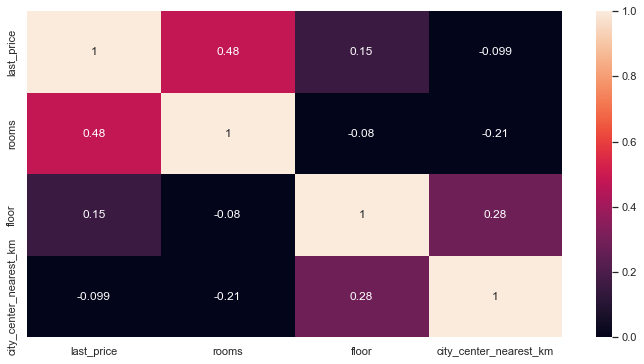

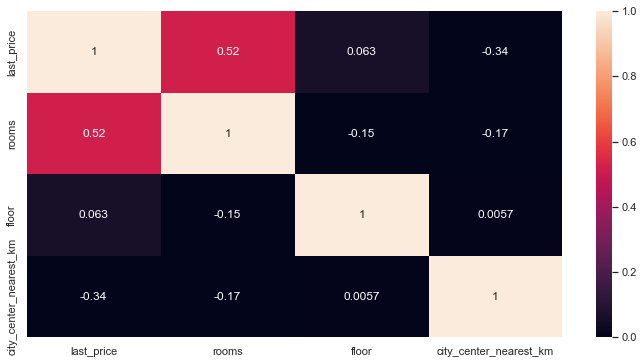

In [38]:
# Матрицы корреляции для обоих датасетов
plt.figure()
sns.set(rc = {'figure.figsize': (12, 6)})
sns.heatmap(pvt_properties_center[['last_price', 'rooms', 'floor', 'city_center_nearest_km', 'first_day_exposition']].corr(),
            annot=True,
            vmin=0,
            vmax=1);

plt.figure()
sns.set(rc = {'figure.figsize': (12, 6)})
sns.heatmap(df_properties[['last_price', 'rooms', 'floor', 'city_center_nearest_km', 'first_day_exposition']].corr(),
            annot=True,
            vmin=0,
            vmax=1);

**Вывод:** для обоих датасетов количество комнат - основной фактор, который влияет на стоимость квартиры. Это ожидаемо, т.к. количество комнат также сильно связно с площадью квартиры.

Интересно, что этаж квартир становится сильно зависим от расстояния до центра для датасета с квартирами в центре. Скорей всего, это объясняется тем, что в центре запрещено стороить небоскребы, а значит там дома будут малоэтажные.

Также, для квартир в центре, расстояние до центра является менее значимым фактором, чем для квартир во всем датасете. Это, скорей всего, связано с тем, что разница в 1 или 5 км от центре перестает быть существенной. Тогда как разница в 25 км и 5 км может быть причиной большой разницы в цене.

## Общий вывод

В ходе проекта мы провели большие раскопки: начали с выделения основных колонок, которые нужны для анализа; потом перешли к отчистке данных и восстановлению пропусков; потом добавили несколько calculated columns в датасет и, наконец, изучили распределения различных величин.

Из проекта видно, что стоимость квартир зависит от многих факторов. Некоторые из этих факторов достаточно очевидные (площадь, например), но некоторые могут иметь нетривиальные зависимости (например, расстояние до центра).